In [64]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.mixture import GaussianMixture
import warnings
import glob
import cv2
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import skfuzzy as fuzz
import os

In [69]:
datasets=os.listdir("C:\\Users\\soumy\\Desktop\\JU\\01.09.2019\\literature\\literature\\")

In [2]:
k=2
thresh=0.2
limit=20
dict1={}
dictoutlier={}
dictfinal={}
dictnotoutlier={}

In [3]:
DataSet="ALOI"
path="C:\\Users\\soumy\\Desktop\\JU\\01.09.2019\\literature\\literature\\"+DataSet+"\\"+DataSet+"_withoutdupl_norm.arff"
#path_img= "C:\\Users\\soumy\\Desktop\\JU\Data for Outlier\\Data for Outlier\\001\\"
data = arff.loadarff(path)

In [5]:
df12=pd.DataFrame(data[0])
#df=df[df['class']=='C001']
from copy import deepcopy
df_copy=deepcopy(df12)

In [6]:
labelsss=df12['outlier']

In [7]:
#for i in range(len(labelsss)):
#   if(labelsss[i][0]==' '):
#        labelsss[i]=labelsss[i][7:11]
#    else:
#        labelsss[i]=labelsss[i][6:9]
    

In [8]:
np.unique(labelsss,return_counts=True)

(array([b"'no'", b"'yes'"], dtype=object), array([48026,  1508], dtype=int64))

In [9]:
df12.drop(columns=['outlier','id'],inplace=True)

In [12]:
from sklearn import preprocessing

x = df12.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df12 = pd.DataFrame(x_scaled)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.784999,0.000018,0.0,0.000093,0.0,0.0,0.0,0.0,0.0,0.139811,...,0.0,0.048171,0.001189,0.0,0.115728,0.023449,0.0002,0.000220,0.034952,0.046914
1,0.958088,0.000000,0.0,0.001671,0.0,0.0,0.0,0.0,0.0,0.019556,...,0.0,0.000000,0.000000,0.0,0.022035,0.007516,0.0000,0.000000,0.001033,0.000000
2,0.938768,0.000000,0.0,0.005146,0.0,0.0,0.0,0.0,0.0,0.018451,...,0.0,0.000000,0.000000,0.0,0.035542,0.011982,0.0000,0.001595,0.019520,0.000000
3,0.954775,0.000000,0.0,0.001427,0.0,0.0,0.0,0.0,0.0,0.024944,...,0.0,0.000000,0.000000,0.0,0.019941,0.000805,0.0000,0.000000,0.000035,0.000000
4,0.933601,0.000000,0.0,0.001682,0.0,0.0,0.0,0.0,0.0,0.037002,...,0.0,0.000000,0.000000,0.0,0.046759,0.002663,0.0000,0.000339,0.001359,0.000000


In [14]:
pd.set_option('use_inf_as_na', True)
columns=df12.columns
df=df12
silhouette=[]
for i in range(limit):
    df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    df=df.reset_index()
    df.drop(columns='index',inplace=True)
    gmmkpp = GaussianMixture(n_components=k,random_state=100).fit(df)
    gmmkm = GaussianMixture(init_params='random',n_components=k,random_state=100).fit(df)
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(df.T, k, 2, error=0.005, maxiter=1000, init=None)
    
    labelskmpp = gmmkpp.predict_proba(df)
    s1=silhouette_score(df, np.argmax(labelskmpp,axis=1))
    labelskm = gmmkm.predict_proba(df)
    s2=silhouette_score(df, np.argmax(labelskm,axis=1))
    s3=silhouette_score(df, np.argmax(u,axis=0))
    s1=abs(s1)
    s2=abs(s2)
    s3=abs(s3)
    
    y_net = s1*labelskmpp + s2*labelskm + s3*u.T
    
    #print(y_net)
    ################## SCORE ###############
    silhouette_avg = silhouette_score(df, np.argmax(y_net,axis=1))
    print('Silhouette Score =',silhouette_avg,'for i =',i+1)
    silhouette.append(silhouette_avg)
    ############### OUTLIER ########################
    if(i==0):
        outliers=np.where(np.max(y_net,axis=1) < thresh)
    else :
        thresh=thresh
        outliers=np.where(np.max(y_net,axis=1) < thresh)
    #if(len(outliers[0])==0):
        #print('All Outliers Removed.... Breaking')
        #break
    print(outliers[0])
    dict1.update({i:outliers[0]})
    mol=np.delete(y_net,outliers[0],axis=0)
    y_net=mol
    df=df.drop(outliers[0])
    df=df.reset_index()
    df.drop(columns='index',inplace=True)
    ylabel=np.argmax(y_net,axis=1)


    labels=pd.Series(ylabel,name="Labels")




    print(np.unique(labels,return_counts=True))
    df=df.join(labels)

    df.update(labels)
    dictoutlier.update({i:list(df[df['Labels']==1].index)})
    dictnotoutlier.update({i:list(df[df['Labels']==0].index)})

    centroids=df.groupby('Labels', as_index=False)[columns].mean()
    centroids=centroids.drop(columns='Labels')
    centroids=centroids.values.tolist()

    for i1 in range(k):
            x=0
            y=0
            for j1 in range(len(columns)):
                x+=np.sqrt(np.abs((df[columns[j1]] - centroids[i1][j1]) ** 2))
            y=np.exp(-1*x)   
            # sqrt((x1 - x2)^2 - (y1 - y2)^2)
            df['distance_from_{}'.format(i1)] =x
            df['Probability_of_{}'.format(i1)]=y



    for j2 in range(k):
        df1=df[df['Labels']==j2]
        for i2 in columns:
            df1[i2]=np.abs(df[i2]-df1['Probability_of_{}'.format(j2)]/df1['distance_from_{}'.format(j2)])
            #print(df1.head())
            df.update(df1[i2])

    df=df[columns]

    #print(df.head(2))
    print('----------------------------------------------------------------------------------------')
    print()


    
    
    
    
    
    

Silhouette Score = 0.23822660050777816 for i = 1
[]
(array([0, 1], dtype=int64), array([ 9545, 39989], dtype=int64))
----------------------------------------------------------------------------------------

Silhouette Score = 0.5032641506445401 for i = 2
[]
(array([0, 1], dtype=int64), array([15370, 34164], dtype=int64))
----------------------------------------------------------------------------------------

Silhouette Score = 0.22263513788184458 for i = 3
[]
(array([0, 1], dtype=int64), array([ 9639, 39895], dtype=int64))
----------------------------------------------------------------------------------------

Silhouette Score = 0.47642020100110993 for i = 4
[]
(array([0, 1], dtype=int64), array([17070, 32464], dtype=int64))
----------------------------------------------------------------------------------------

Silhouette Score = 0.17466050408084494 for i = 5
[]
(array([0, 1], dtype=int64), array([ 9637, 39897], dtype=int64))
--------------------------------------------------------

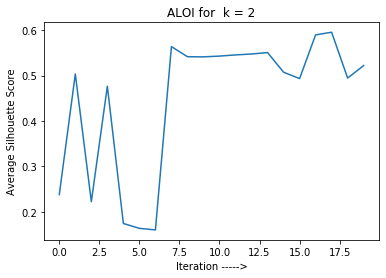

In [25]:

m=np.argmax(silhouette)

print('Best for m='+str(m+1)+' >=> '+ str(max(silhouette)))


Best for m=18 >=> 0.5951282675876135


17

In [59]:
z=[]
y1=[]
for i in dictoutlier[m]:
    z.append(labelsss[i])
    
f00=np.unique(z,return_counts=True)
z=str(list(foo[0])+list(foo[1]))

In [60]:

for i in dictnotoutlier[m]:
    y1.append(labelsss[i])
    
foo=np.unique(y1,return_counts=True)
y1=str(list(foo[0])+list(foo[1]))

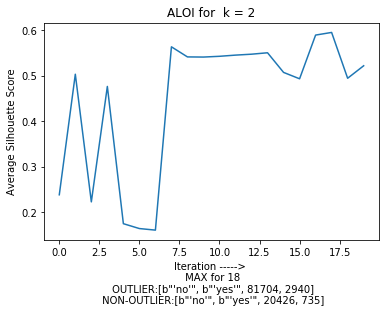

In [67]:
fig=plt.figure()
f=plt.plot(silhouette)
plt.title(DataSet+' for  k = '+ str(k) )
plt.xlabel("Iteration -----> \n MAX for "+str(m+1)+"\n OUTLIER:"+z+"\n NON-OUTLIER:"+y1)
plt.ylabel("Average Silhouette Score")

plt.savefig('C:\\Users\\soumy\\Desktop\\JU\\01.09.2019\\literature\\Results\\'+DataSet+'.png',bbox_inches='tight')

In [20]:
#from sklearn.ensemble import IsolationForest

#clf = IsolationForest(n_estimators=100, warm_start=True)
#y=clf.fit_predict(df12)  # fit 10 trees  

In [21]:
#np.unique(y,return_counts=True)

In [22]:
#from sklearn_extensions.fuzzy_kmeans import KMedians, FuzzyKMeans, KMeans


In [23]:
#kmeans = KMeans(k=2)
#kmeans.fit(df12)